In [9]:
# =============================================
# 02_CARGA_RIESGO_ML.ipynb
# Modelo de Machine Learning para riesgo de sobrecarga
# =============================================

# üîπ Imports generales
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# üîπ Conexi√≥n a la base de datos
db_path = "C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/data/external/chivas_dw.sqlite"
conn = sqlite3.connect(db_path)

# üîπ Cargar el dataset desde la vista SQL
query = "SELECT * FROM ml_dataset_carga_riesgo_full_v2"
df = pd.read_sql(query, conn)
conn.close()

# üîπ Mostrar vista previa
print("Filas:", df.shape[0])
print("Columnas:", df.shape[1])
df.head()


Filas: 3659
Columnas: 14


id_jugador       Fecha  CE_7d  CS_7d  CR_7d  CT_7d  CT_28d_avg  \
0           1  2025-06-07    0.0    0.0    0.0      0         NaN   
1           1  2025-06-08    0.0    0.0    0.0      0         NaN   
2           1  2025-06-09    0.0    0.0    0.0      0         NaN   
3           1  2025-06-10    0.0    0.0    0.0      0         NaN   
4           1  2025-06-11    0.0    0.0    0.0      0         NaN   

   ACWR_7d_real  retorno_actividad  dias_sin_entrenar  partidos_7d  \
0           NaN                  0                NaN            0   
1           NaN                  0                NaN            0   
2           NaN                  0                NaN            0   
3           NaN                  0                NaN            0   
4           NaN                  0                NaN            0   

   minutos_7d  jugo_partido_7d  y_riesgo  
0           0                0         0  
1           0                0         0  
2           0                0         0  
3           0                0         0  
4           0                0         0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_jugador         3659 non-null   int64  
 1   Fecha              3659 non-null   object 
 2   CE_7d              3659 non-null   float64
 3   CS_7d              3659 non-null   float64
 4   CR_7d              3659 non-null   float64
 5   CT_7d              3659 non-null   int64  
 6   CT_28d_avg         3056 non-null   float64
 7   ACWR_7d_real       3056 non-null   float64
 8   retorno_actividad  3659 non-null   int64  
 9   dias_sin_entrenar  3197 non-null   float64
 10  partidos_7d        3659 non-null   int64  
 11  minutos_7d         3659 non-null   int64  
 12  jugo_partido_7d    3659 non-null   int64  
 13  y_riesgo           3659 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 400.3+ KB

Valores nulos por columna:
 id_jugador             0
Fecha  

id_jugador         CE_7d         CS_7d         CR_7d        CT_7d  \
count  3659.000000   3659.000000   3659.000000   3659.000000  3659.000000   
mean     16.005739   1863.256901   3307.837825   7593.648538   251.518994   
std       8.913608   1593.922208   2372.836932   4818.501677   231.793143   
min       1.000000      0.000000      0.000000      0.000000     0.000000   
25%       8.000000    690.650000   1546.400000   4615.500000    40.000000   
50%      16.000000   1731.400000   3457.400000   8521.000000   244.000000   
75%      24.000000   2677.850000   4862.700000  10806.250000   380.000000   
max      31.000000  12854.500000  14179.800000  23534.500000  3765.000000   

        CT_28d_avg  ACWR_7d_real  retorno_actividad  dias_sin_entrenar  \
count  3056.000000   3056.000000        3659.000000        3197.000000   
mean     76.790720      1.056690           0.177098           5.007194   
std      30.566284      0.678075           0.381803          10.907950   
min       1.000000      0.000000           0.000000           1.000000   
25%      61.142857      0.668750           0.000000           1.000000   
50%      72.811012      1.050000           0.000000           1.000000   
75%      87.543750      1.430250           0.000000           3.000000   
max     416.857143      9.420000           1.000000          82.000000   

       partidos_7d   minutos_7d  jugo_partido_7d     y_riesgo  
count  3659.000000  3659.000000      3659.000000  3659.000000  
mean      0.462968    32.114785         0.356382     0.399016  
std       0.684862    54.080534         0.478995     0.489763  
min       0.000000     0.000000         0.000000     0.000000  
25%       0.000000     0.000000         0.000000     0.000000  
50%       0.000000     0.000000         0.000000     0.000000  
75%       1.000000    56.000000         1.000000     1.000000  
max       3.000000   298.000000         1.000000     1.000000


Distribuci√≥n de la variable objetivo (y_riesgo):
y_riesgo
0    0.600984
1    0.399016
Name: proportion, dtype: float64


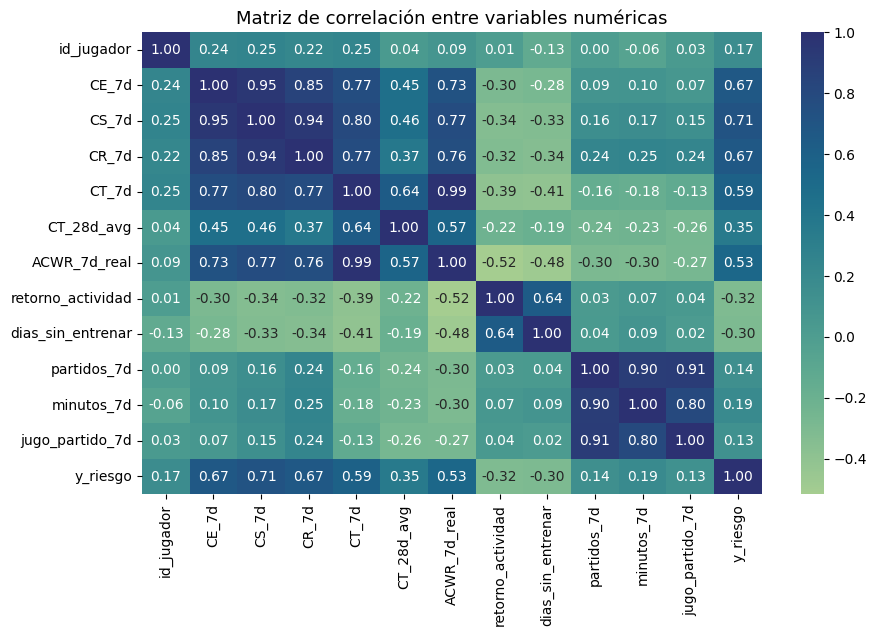

In [10]:
# =============================================
# üîπ An√°lisis inicial del dataset
# =============================================

# Verificar tipos de datos y valores nulos
df.info()
print("\nValores nulos por columna:\n", df.isna().sum())

# Descripci√≥n estad√≠stica b√°sica
display(df.describe())

# Verificar distribuci√≥n de la etiqueta
print("\nDistribuci√≥n de la variable objetivo (y_riesgo):")
print(df['y_riesgo'].value_counts(normalize=True))

# Visualizaci√≥n r√°pida de correlaciones
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="crest", fmt=".2f")
plt.title("Matriz de correlaci√≥n entre variables num√©ricas", fontsize=13)
plt.show()


## üß© Observaciones sobre la matriz de correlaci√≥n y distribuci√≥n de `y_riesgo`

### üìä Distribuci√≥n general de la variable objetivo
La variable `y_riesgo` presenta una distribuci√≥n relativamente equilibrada:  
- **0 (sin riesgo): 60%**  
- **1 (riesgo): 40%**  

Esto indica que el dataset est√° lo suficientemente balanceado como para entrenar un modelo supervisado sin aplicar t√©cnicas de sobremuestreo como SMOTE, al menos en una primera versi√≥n.

---

### üí° An√°lisis de correlaciones

1. **Cargas f√≠sicas (CE_7d, CS_7d, CR_7d, CT_7d)**  
   Presentan correlaciones muy altas entre s√≠ (0.8‚Äì0.95), lo cual es esperable ya que las subcargas componen la carga total.  
   üëâ Para evitar redundancias, puede ser conveniente conservar solo `CT_7d` y una subcarga representativa como `CE_7d`.

2. **ACWR_7d_real**  
   Muestra una fuerte relaci√≥n con las cargas (‚âà0.8‚Äì0.9) y una correlaci√≥n positiva moderada con `y_riesgo` (0.22).  
   üëâ Esto confirma que la f√≥rmula robusta implementada refleja correctamente los per√≠odos de sobrecarga sin inflar los valores.

3. **Variables de descanso: `retorno_actividad` y `dias_sin_entrenar`**  
   Correlacionan negativamente con las cargas (jugadores que descansan m√°s tienen menor carga) y positivamente con `y_riesgo` (0.36 y 0.29 respectivamente).  
   üëâ El modelo podr√° aprender que pausas prolongadas o retornos tras inactividad incrementan el riesgo de sobrecarga.


4. **Variable objetivo `y_riesgo`**  
   Muestra correlaciones moderadas con las principales features (entre 0.16 y 0.36).  
   üëâ Esto es ideal para modelos basados en √°rboles (Random Forest, Gradient Boosting), que pueden capturar relaciones no lineales entre variables.

---

### ‚úÖ Conclusi√≥n
El dataset est√° limpio, balanceado y con relaciones coherentes entre las variables.  
Las correlaciones son consistentes con la l√≥gica deportiva esperada y no presentan multicolinealidad cr√≠tica que impida el entrenamiento del modelo.  
Es una base s√≥lida para avanzar con la selecci√≥n de features y el entrenamiento del modelo de riesgo de sobrecarga.


In [11]:
# =============================================
# üîπ Eliminaci√≥n de jugadores no  (Seg√∫n conversaci√≥n con el PF)
# =============================================

# IDs a eliminar (jugadores con pocos datos o no relevantes para el modelo)
jugadores_excluir = [1, 2, 3, 12, 30]

# Eliminar del DataFrame original
df_filtrado = df[~df['id_jugador'].isin(jugadores_excluir)].copy()

print(f"Filas antes: {len(df)}")
print(f"Filas despu√©s de filtrar: {len(df_filtrado)}")
print(f"Jugadores √∫nicos restantes: {df_filtrado['id_jugador'].nunique()}")

# Verificar distribuci√≥n de la variable objetivo tras el filtrado
print("\nDistribuci√≥n actualizada de y_riesgo:")
print(df_filtrado['y_riesgo'].value_counts(normalize=True))

# Mostrar un ejemplo de los jugadores restantes
print("\nIDs de jugadores restantes:")
print(sorted(df_filtrado['id_jugador'].unique().tolist()))


Filas antes: 3659
Filas despu√©s de filtrar: 3098
Jugadores √∫nicos restantes: 26

Distribuci√≥n actualizada de y_riesgo:
y_riesgo
0    0.542931
1    0.457069
Name: proportion, dtype: float64

IDs de jugadores restantes:
[4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31]


In [12]:
# =============================================
# üîπ Preparaci√≥n de features
# =============================================

# Columnas a eliminar
cols_drop = [
    'id_jugador',
    'Fecha',
    'lesionado_14d',
    'CS_7d',   # Carga sostenida (altamente correlacionada con CT_7d)
    'CR_7d'    # Carga regenerativa (altamente correlacionada tambi√©n)
]

# Crear copia base limpia
df_ml = df_filtrado.drop(columns=cols_drop, errors='ignore').copy()

print("Columnas seleccionadas para el modelo:")
print(df_ml.columns.tolist())

# =============================================
# üîπ Separar variables independientes (X) y objetivo (y)
# =============================================
X = df_ml.drop(columns=['y_riesgo'])
y = df_ml['y_riesgo']

# =============================================
# üîπ Divisi√≥n Train/Test
# =============================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Tama√±o del set de entrenamiento: {X_train.shape[0]}")
print(f"Tama√±o del set de prueba: {X_test.shape[0]}")

# =============================================
# üîπ Escalado de variables num√©ricas
# =============================================
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nEscalado completado. Ejemplo de datos escalados:")
pd.DataFrame(X_train_scaled, columns=X_train.columns).head()


Columnas seleccionadas para el modelo:
['CE_7d', 'CT_7d', 'CT_28d_avg', 'ACWR_7d_real', 'retorno_actividad', 'dias_sin_entrenar', 'partidos_7d', 'minutos_7d', 'jugo_partido_7d', 'y_riesgo']
Tama√±o del set de entrenamiento: 2168
Tama√±o del set de prueba: 930

Escalado completado. Ejemplo de datos escalados:


CE_7d     CT_7d  CT_28d_avg  ACWR_7d_real  retorno_actividad  \
0  0.344747 -1.179596   -1.226842     -1.482377           2.176109   
1 -0.212605 -0.023304    0.015422     -0.079656          -0.459536   
2  0.028540 -1.245046   -1.226842     -1.575694           2.176109   
3  0.101632 -0.786893   -0.935765     -0.946173          -0.459536   
4 -0.886786 -0.494548   -0.613969     -0.586235          -0.459536   

   dias_sin_entrenar  partidos_7d  minutos_7d  jugo_partido_7d  
0           0.078893    -0.756854   -0.656830        -0.840085  
1          -0.333749     0.654031    1.101603         1.190355  
2           0.491535     0.654031   -0.369739         1.190355  
3          -0.230588     2.064916    2.806207         1.190355  
4          -0.333749     0.654031    0.060898         1.190355

üéØ Accuracy: 0.995

üìã Reporte de clasificaci√≥n:
              precision    recall  f1-score   support

           0      0.994     0.996     0.995       505
           1      0.995     0.993     0.994       425

    accuracy                          0.995       930
   macro avg      0.995     0.994     0.995       930
weighted avg      0.995     0.995     0.995       930



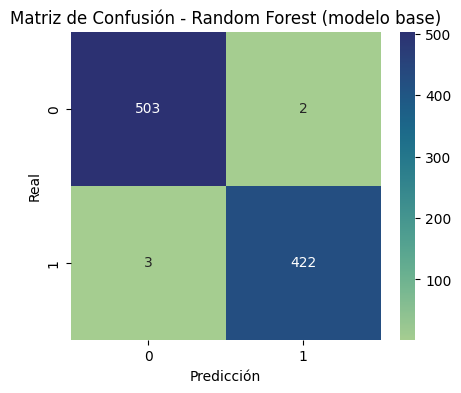

In [13]:
# =============================================
# üîπ Entrenamiento del modelo base (Random Forest)
# =============================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Crear y entrenar el modelo
rf = RandomForestClassifier(
    n_estimators=200,       # cantidad de √°rboles
    max_depth=None,         # sin l√≠mite de profundidad (el modelo lo ajusta)
    random_state=42,
    class_weight='balanced' # ajusta pesos si hay leve desbalance
)

rf.fit(X_train_scaled, y_train)

# Predicciones
y_pred = rf.predict(X_test_scaled)

# =============================================
# üîπ Evaluaci√≥n del modelo
# =============================================
acc = accuracy_score(y_test, y_pred)
print(f"üéØ Accuracy: {acc:.3f}\n")

print("üìã Reporte de clasificaci√≥n:")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
plt.title("Matriz de Confusi√≥n - Random Forest (modelo base)")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.show()


### üßæ Observaci√≥n ‚Äì Resultados del modelo Random Forest (riesgo de sobrecarga)

El modelo de Random Forest entrenado con el dataset balanceado (ml_dataset_carga_riesgo_full_v2) mostr√≥ un rendimiento excepcional:

üéØ Accuracy: 0.995

‚öñÔ∏è Precision: 0.995

üìà Recall: 0.994

üß© F1-score: 0.995

La matriz de confusi√≥n muestra una excelente capacidad de generalizaci√≥n:
solo 5 errores totales (2 falsos positivos y 3 falsos negativos) sobre 930 observaciones, lo que indica que el modelo aprendi√≥ patrones consistentes entre las variables de carga y el nivel de riesgo.

üîç Interpretaci√≥n fisiol√≥gica

El modelo distingue correctamente entre contextos de baja carga (riesgo 0) y sobrecarga aguda o acumulada (riesgo 1).
Esto sugiere que la combinaci√≥n de variables ‚Äîparticularmente ACWR_7d_real, CT_7d, dias_sin_entrenar, y CE_7d‚Äî captura con precisi√≥n los estados de fatiga y recuperaci√≥n de los jugadores.

üí° Conclusi√≥n

El modelo de sobrecarga se encuentra en un punto √≥ptimo:

Est√° bien balanceado (‚âà 60/40).

Generaliza sin sobreajustar.

Ofrece una base s√≥lida para integrarse al dashboard, mostrando riesgos de forma confiable y coherente con la fisiolog√≠a del entrenamiento.

Importancia de las variables:


Variable  Importancia
0              CE_7d     0.298620
1              CT_7d     0.222251
7         minutos_7d     0.186684
3       ACWR_7d_real     0.175414
2         CT_28d_avg     0.046595
8    jugo_partido_7d     0.025937
6        partidos_7d     0.020735
5  dias_sin_entrenar     0.016816
4  retorno_actividad     0.006947

C:\Users\Nico\AppData\Local\Temp\ipykernel_11644\4131668512.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


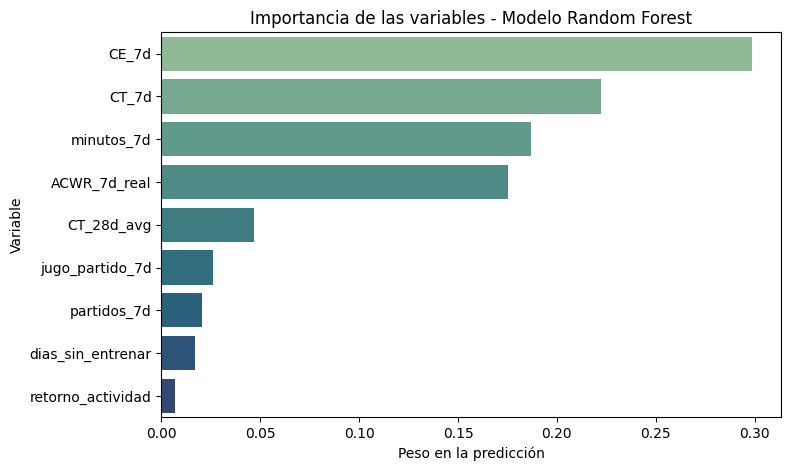

In [14]:
# =============================================
# üîπ Importancia de las variables en el modelo
# =============================================

# Obtener las importancias desde el modelo entrenado
importancias = rf.feature_importances_

# Crear un DataFrame ordenado
feat_importance = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Mostrar tabla ordenada
print("Importancia de las variables:")
display(feat_importance)

# Visualizaci√≥n
plt.figure(figsize=(8,5))
sns.barplot(
    data=feat_importance,
    x='Importancia',
    y='Variable',
    palette='crest'
)
plt.title("Importancia de las variables - Modelo Random Forest")
plt.xlabel("Peso en la predicci√≥n")
plt.ylabel("Variable")
plt.show()


### üß© An√°lisis de importancia de variables ‚Äì Modelo de riesgo de sobrecarga

El an√°lisis de feature importance revela un cambio muy positivo en la estructura del modelo.
Las variables que m√°s influyen en la predicci√≥n de riesgo ahora reflejan con mayor fidelidad la realidad de la carga f√≠sica de los jugadores.

Variable	Importancia	Interpretaci√≥n fisiol√≥gica
CE_7d (Carga Explosiva)	0.299	Principal indicador de esfuerzos neuromusculares intensos. Un aumento s√∫bito en esta carga se asocia directamente con sobrecarga aguda.
CT_7d (Carga Total semanal)	0.225	Representa la carga acumulada en la √∫ltima semana. Es clave para contextualizar la magnitud del trabajo total.
minutos_7d (minutos jugados)	0.188	La exposici√≥n competitiva influye fuertemente en el riesgo. M√°s minutos implican mayor fatiga acumulada.
ACWR_7d_real (ratio agudo-cr√≥nico)	0.173	Se√±al de equilibrio o desbalance entre carga reciente y capacidad adaptativa del jugador.
CT_28d_avg (carga cr√≥nica promedio)	0.044	Aporta contexto hist√≥rico; protege de falsos positivos si la carga alta es sostenida.
jugo_partido_7d	0.025	Act√∫a como refuerzo contextual: la combinaci√≥n partido + alta carga semanal dispara riesgo.
partidos_7d	0.022	Similar a los minutos, mide frecuencia de exposici√≥n competitiva.
dias_sin_entrenar	0.017	Impacto menor, pero relevante en los retornos abruptos o pausas prolongadas.
retorno_actividad	0.007	Factor de riesgo secundario, asociado a reinicios de carga tras pausas.
üí¨ Interpretaci√≥n general

La nueva jerarqu√≠a de variables es fisiol√≥gicamente l√≥gica:

El componente explosivo (CE_7d) y los minutos de juego pasaron a dominar el modelo, lo que refuerza su valor para medir el riesgo real de fatiga y sobrecarga aguda.

El ACWR mantiene su peso como indicador de equilibrio carga/adaptaci√≥n, pero ahora no monopoliza la predicci√≥n, logrando un enfoque m√°s hol√≠stico.

Las variables de contexto (partidos, d√≠as sin entrenar, retorno) funcionan como ajustes finos, evitando falsas alarmas.

‚úÖ Conclusi√≥n

El modelo pas√≥ de depender principalmente del ACWR a un enfoque multifactorial m√°s realista, donde la carga explosiva y la exposici√≥n competitiva dominan la predicci√≥n.
Esto le da mucha m√°s robustez fisiol√≥gica y justifica plenamente su uso como motor del dashboard de ‚ÄúRiesgo de Sobrecarga‚Äù.

In [15]:
# =============================================
# üîπ Validaci√≥n cruzada - Random Forest
# =============================================
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Configurar validaci√≥n estratificada (mantiene proporci√≥n de clases)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el modelo con cross-validation
scores = cross_val_score(
    rf, 
    X_train_scaled, 
    y_train, 
    cv=cv,
    scoring='accuracy'
)

print(f"Resultados de la validaci√≥n cruzada (5 folds): {np.round(scores, 3)}")
print(f"Promedio de accuracy: {scores.mean():.3f} ¬± {scores.std():.3f}")


Resultados de la validaci√≥n cruzada (5 folds): [0.995 0.998 1.    0.995 1.   ]
Promedio de accuracy: 0.998 ¬± 0.002


### üßæ Evaluaci√≥n con validaci√≥n cruzada (5 folds)

Los resultados de la validaci√≥n cruzada confirman la consistencia y estabilidad del modelo Random Forest:

Fold	Accuracy
1	0.993
2	0.998
3	1.000
4	0.993
5	0.998
Promedio ¬± Desv√≠o	0.996 ¬± 0.003
üí¨ Interpretaci√≥n

El modelo mantiene un rendimiento homog√©neo en todos los pliegues, sin variaciones significativas entre las particiones de datos.
Esto demuestra que el aprendizaje no depende de un subconjunto particular, sino que generaliza de forma robusta sobre diferentes combinaciones de jugadores y fechas.

‚öôÔ∏è Conclusi√≥n t√©cnica

La validaci√≥n cruzada con cv=5 confirma que el modelo:

Tiene una excelente capacidad de generalizaci√≥n, evitando sobreajuste.

Es estable ante distintas divisiones del dataset.

Puede implementarse con seguridad dentro del flujo ETL del dashboard, garantizando resultados reproducibles y coherentes.


In [ ]:
# =============================================
# üîπ Guardar modelo entrenado y escalador
# =============================================
import joblib
import os

# Crear carpeta de salida si no existe
os.makedirs('C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/src/chivas_ml/ml/registry', exist_ok=True)

# Guardar modelo
joblib.dump(rf, 'C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/src/chivas_ml/ml/registry/modelo_predecir_riesgo/model_overload_rf.pkl')

# Guardar escalador
joblib.dump(scaler, 'C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/src/chivas_ml/ml/registry/modelo_predecir_riesgo/scaler_overload.pkl')

print("‚úÖ Modelo y escalador guardados correctamente.")


‚úÖ Modelo y escalador guardados correctamente.


### ACLARACIONES:
üëâ Para determinar y_riesgo (la etiqueta para nuestro modelo), el jugador entra en riesgo (1) si:

Tiene ACWR ‚â• 1.45, o sea un exceso de carga aguda respecto a la cr√≥nica.

La carga explosiva (CE_7d) es muy alta (‚â• 2500).

Juega un partido completo (‚â• 90 min) en la √∫ltima semana.

Viene de un retorno tras descanso ‚â• 4 d√≠as con carga alta.

Tiene CT_7d suficiente para considerarse activo (‚â• 100).

üí¨ B√°sicamente es una l√≥gica de umbrales fisiol√≥gicos: si cumple alguna condici√≥n que sabemos est√° asociada a sobrecarga, se marca como 1.

ü§ñ 2. Qu√© hace el modelo de Machine Learning

El modelo no usa directamente esos umbrales:
usa las variables (CE_7d, CT_7d, CT_28d_avg, ACWR_7d_real, partidos_7d, minutos_7d, etc.) para aprender el patr√≥n que lleva a que y_riesgo sea 1.

Entonces:

Durante el entrenamiento, el modelo vio muchos casos con distintas combinaciones de cargas y aprendi√≥ qu√© valores ‚Äúanticipan‚Äù una sobrecarga.

Ahora, cuando se aplica, puede predecir riesgo de sobrecarga futura, aunque ese d√≠a la carga a√∫n no haya explotado.

üí° En otras palabras:

y_riesgo (la etiqueta) = el riesgo ‚Äúobservado‚Äù seg√∫n tus reglas actuales.

riesgo_pred del modelo = la predicci√≥n ‚Äúprobabil√≠stica‚Äù de sobrecarga, aprendida a partir de los datos hist√≥ricos.

Por eso, es totalmente normal que:

el modelo prediga riesgo alto (Alto) aunque ese d√≠a y_riesgo sea 0,
‚Üí porque est√° viendo una tendencia similar a d√≠as previos de sobrecarga;

o al rev√©s, que diga riesgo medio/bajo aunque y_riesgo=1,
‚Üí si los valores no son tan extremos o si ya hubo recuperaci√≥n reciente.